In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import os

In [2]:
def preprocess_image(img):
    img = img.resize((64,64),resample=1)
    arr = np.array(img)
    arr = np.expand_dims(arr, axis=0)
    return arr/255.0

def compute_distance(vec1,vec2,norm1,norm2):
    arr1 = vec1.ravel()
    arr2 = vec2.ravel()
    return arr1.dot(arr2)/(norm1*norm2)

class Channel(Enum):
    RED_ONLY = 0
    GREEN_ONLY = 1
    BLUE_ONLY = 2
    ALL = 3    

In [3]:
# Loads Keras model
model = tf.keras.models.load_model('dogs_cats_cnn.h5')

In [4]:
# Reads all images paths from dataset and shuffle them
images = []
path = '../../datasets/classification/cats and dogs/'
for root,_,files in os.walk(path):
    for file in files:
        if '.jpg' in file:
            images.append(os.path.join(root,file))
images = np.random.permutation(images)

In [5]:
# Precompute targets norms
num_targets = 6
targets = []
for i in range(num_targets):
    img = preprocess_image(Image.open(images[i]))
    vec = img.ravel()
    targets.append((img[0,:,:,:],vec,np.sqrt(vec.T.dot(vec))))

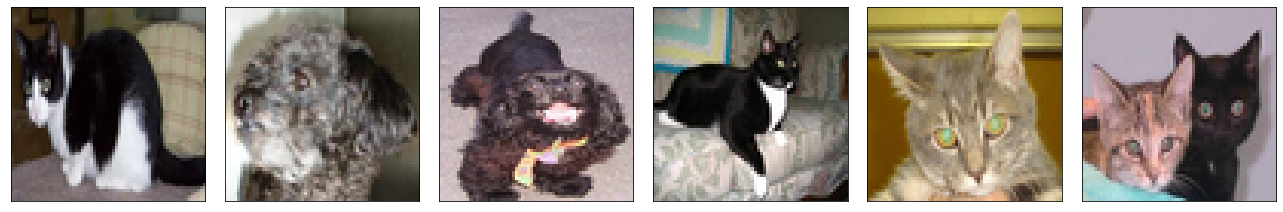

In [6]:
fig, axes = plt.subplots(1,num_targets)
fig.set_size_inches(3*num_targets,3)
fig.set_tight_layout(tight=0.1)
for i,ax in enumerate(axes.ravel()):
    ax.imshow(targets[i][0])
    ax.set_xticks(())
    ax.set_yticks(())

In [7]:
# Find closest neigbors
num_queries = 500
distances = np.zeros((num_targets,num_queries))
for j in range(num_targets,num_targets+num_queries):
    img = preprocess_image(Image.open(images[j]))
    query = img.ravel()
    query_norm = np.sqrt(query.T.dot(query))
    for i,target in enumerate(targets):
        distances[i,j-num_targets] = compute_distance(target[1],query,target[2],query_norm)
num_closest = 5
closest = distances.argsort(axis=1)[:,-1:-num_closest-1:-1] + num_targets

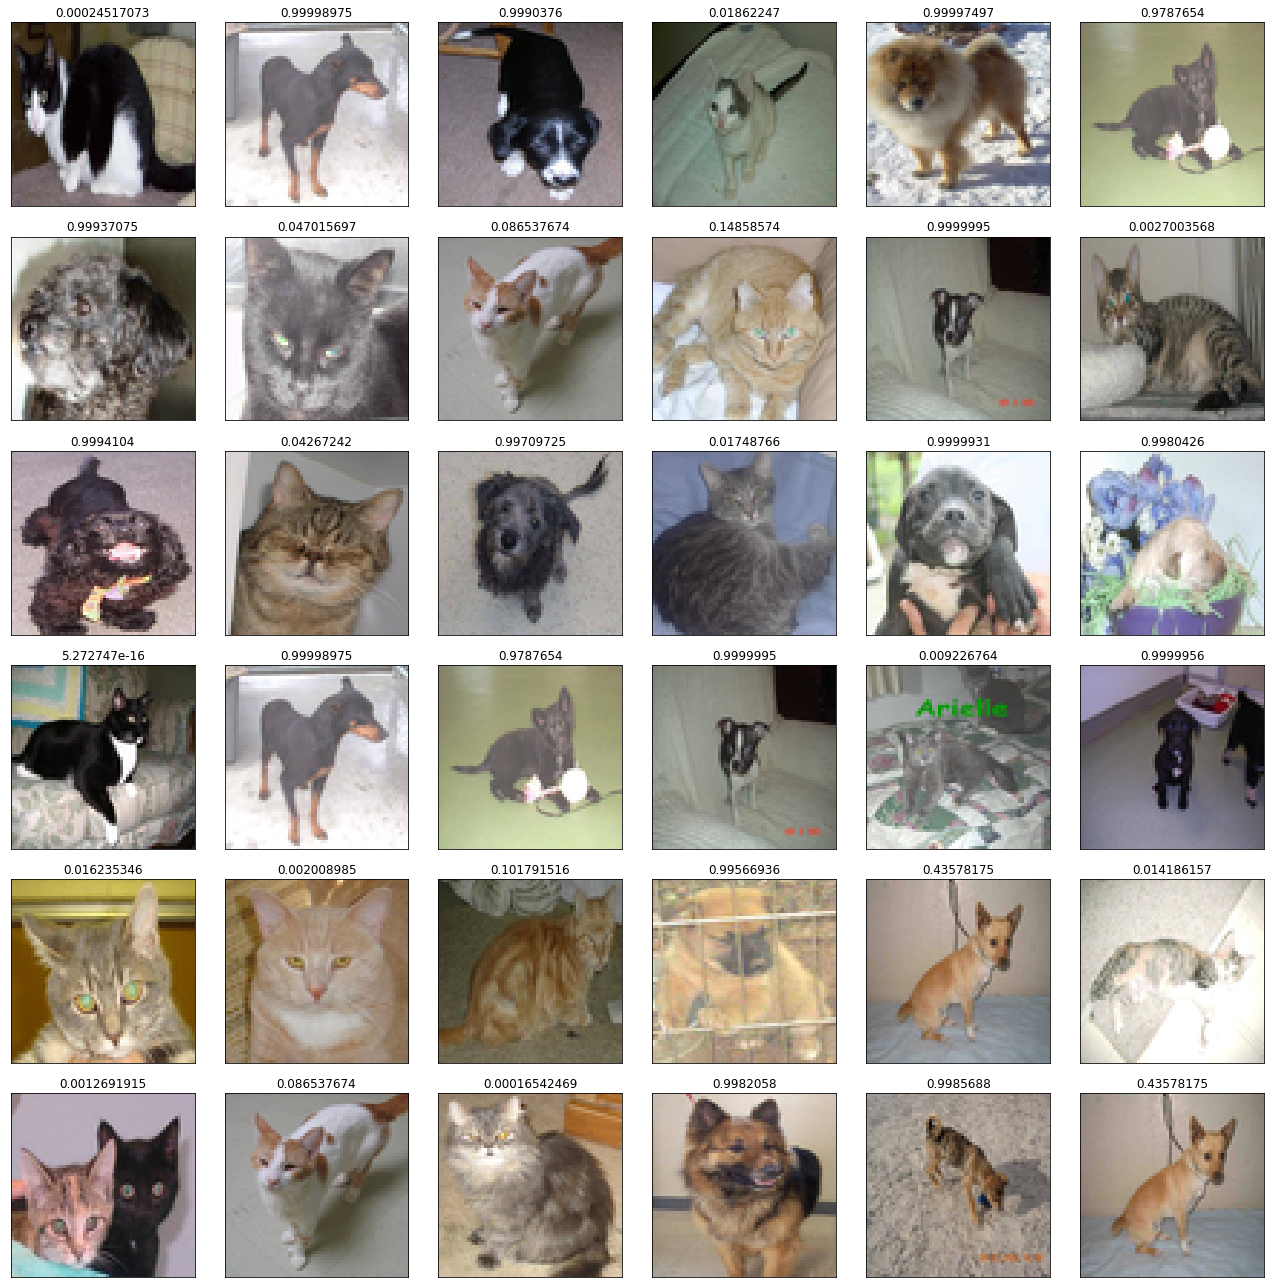

In [8]:
# Plots nearest neighbors
channel = Channel.ALL
cols = num_closest + 1
rows = num_targets
fig, axes = plt.subplots(rows,cols)
fig.set_size_inches(3*cols,3*cols)
fig.set_tight_layout(tight=0.1)
for i,ax in enumerate(axes.ravel()):
    column = i % (cols)
    row = int(i / cols)
    if column == 0:
        arr = targets[row][1].reshape(-1,64,64,3)
        img = targets[row][0]  
    else:
        arr = preprocess_image(Image.open(images[closest[row,column-1]]))
        img = arr[0,:,:,:]
    
    if channel == Channel.RED_ONLY:
        temp = img.copy()
        temp[:,:,1] = 0
        temp[:,:,2] = 0
    elif channel == Channel.GREEN_ONLY:
        temp = img.copy()
        temp[:,:,0] = 0
        temp[:,:,2] = 0
    elif channel == Channel.BLUE_ONLY:
        temp = img.copy()
        temp[:,:,0] = 0
        temp[:,:,1] = 0
    else:
        temp = img
        
    ax.imshow(temp)   
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(model.predict(arr)[0][0])